<a href="https://colab.research.google.com/github/abbyambita/Diagnosing-COVID-from-CT-Scan-Images/blob/main/transfer_learning_with_sagan_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os 

os.chdir("/content/gdrive/My Drive")

!ls  '/content/gdrive/My Drive/CS 284 Mini-Project/Code/model_backup/sagan/git/batch_size=64,epoch=1500/resnet152_epoch_50.pth'

%cd "/content/gdrive/My Drive/CS 284 Mini-Project/Code"

'/content/gdrive/My Drive/CS 284 Mini-Project/Code/model_backup/sagan/git/batch_size=64,epoch=1500/resnet152_epoch_50.pth'
/content/gdrive/.shortcut-targets-by-id/1eVFVz23F6ROX0s10Oe3tT9HVzr502iW2/CS 284 Mini-Project/Code


In [3]:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists

plt.ion()

In [4]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

cuda:0
CUDA is available!  Training on GPU ...


In [6]:
from sklearn.model_selection import train_test_split

import collections

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize((224, 224)),   
                                 transforms.CenterCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'test': transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
}

data_dir = 'revised-git'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#load synthetic data
sagan_synthetic_dataset = datasets.ImageFolder(root='sagan_output_images/git/batch_size=64,epoch=700',transform = data_transforms['train'])
#print(len(sagan_synthetic_dataset))
print(len(image_datasets['train']))

indices = np.arange(len(sagan_synthetic_dataset))
train_indices, test_indices = train_test_split(indices, train_size=500*2, stratify=sagan_synthetic_dataset.targets)
train_dataset = torch.utils.data.Subset(sagan_synthetic_dataset, train_indices)
#train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=32)
print(len(train_dataset))
dataset = torch.utils.data.ConcatDataset([image_datasets['train'], train_dataset])

dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=True, num_workers=4)
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=True, num_workers=4)

dataset_sizes = {
    'train':len(dataset),
    'val': len(image_datasets['val']),
    'test': len(image_datasets['test'])
}
class_names = image_datasets['train'].classes

425
1000


In [8]:
print(dataset_sizes)
print(class_names)

{'train': 1425, 'val': 118, 'test': 203}
['covid', 'noncovid']


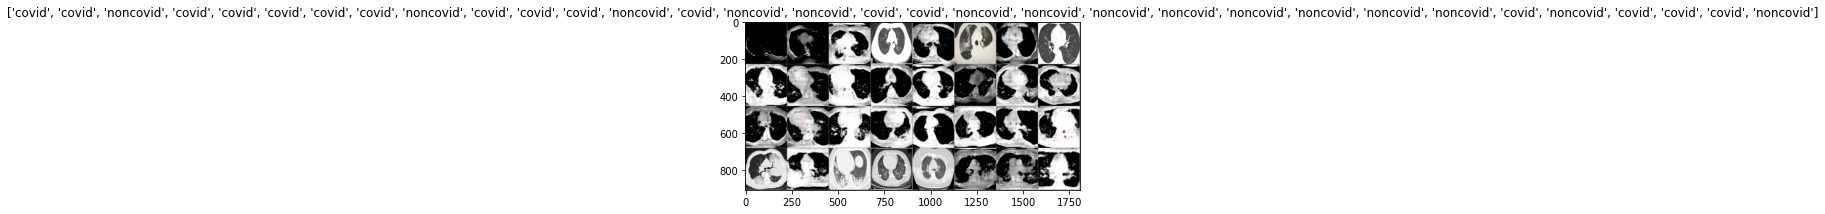

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
#remove scheduler

#def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
def train_model(model, criterion, optimizer, num_epochs=3):

    "Training begins..."


    train_losses = []
    test_losses = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
              train_losses.append(epoch_loss)
            else:
              test_losses.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, test_losses

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

def evaluate_performance(labels, preds, name, num_epochs):
  label = ['noncovid', 'covid']
  #print(confusion_matrix)
  conf_matrix = confusion_matrix(labels, preds)
  print(conf_matrix)

  # Per-class accuracy
  class_accuracy=100*conf_matrix.diagonal()/conf_matrix.sum(1)
  print(class_accuracy)

  print("Accuracy score:", accuracy_score(labels, preds))
  print(classification_report(labels, preds))

  report = classification_report(labels, preds, output_dict = True)
  df = pd.DataFrame(report).transpose()
  df.to_csv('model_result/sagan/git/'+name+'_epochs_'+str(num_epochs)+'_classification_report.csv', index = False)


  plt.figure()
  plot_confusion_matrix(conf_matrix, classes=['NonCovid', 'Covid'],
                      title='Confusion matrix')
  plt.savefig('plots/sagan/git/'+name+'_epochs_'+str(num_epochs)+'.png')
  plt.show()

In [12]:
# Do validation on the test set
def test(model, dataloaders, device, name, num_epochs):

  "Testing begins..."
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  nb_classes = 2

  #confusion_matrix = torch.zeros(nb_classes, nb_classes)
  predlist = torch.zeros(0, dtype = torch.long, device = 'cpu')
  labellist = torch.zeros(0, dtype = torch.long, device = 'cpu')


  for images, labels in dataloaders['test']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

    _, preds = torch.max(output, 1)
    # for t, p in zip(labels.view(-1), preds.view(-1)):
    #   confusion_matrix[t.long(), p.long()] += 1
    predlist=torch.cat([predlist,preds.view(-1).cpu()])
    labellist = torch.cat([labellist, labels.view(-1).cpu()])

    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

  evaluate_performance(labellist.numpy(), predlist.numpy(), name, num_epochs)

In [13]:
# Do validation on the test set (from another dataset)
def test_on_another_data(model, test_data, device, name, num_epochs):

  "Testing begins..."
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  nb_classes = 2

  #confusion_matrix = torch.zeros(nb_classes, nb_classes)
  predlist = torch.zeros(0, dtype = torch.long, device = 'cpu')
  labellist = torch.zeros(0, dtype = torch.long, device = 'cpu')


  for images, labels in test_data:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

    _, preds = torch.max(output, 1)
    # for t, p in zip(labels.view(-1), preds.view(-1)):
    #   confusion_matrix[t.long(), p.long()] += 1
    predlist=torch.cat([predlist,preds.view(-1).cpu()])
    labellist = torch.cat([labellist, labels.view(-1).cpu()])

    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

  evaluate_performance(labellist.numpy(), predlist.numpy(), name, num_epochs)

<h1>Models</h1>

In [14]:
from collections import OrderedDict


# classifier = nn.Sequential(OrderedDict([
#     ('fcl1', nn.Linear(1024,256)),
#     ('dp1', nn.Dropout(0.3)),
#     ('r1', nn.ReLU()),
#     ('fcl2', nn.Linear(256,32)),
#     ('dp2', nn.Dropout(0.3)),
#     ('r2', nn.ReLU()),
#     ('fcl3', nn.Linear(32,2)),
#     #('out', nn.LogSoftmax(dim=1)),
# ]))

In [15]:
train_losses_all = []
test_losses_all = []

In [16]:
def run_model(model, name, freeze = False):
  # Freeze parameters so we don't backprop through them
  for param in model.parameters():
    param.requires_grad = freeze

  #model.classifier = classifier


  if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()
    
  # NLLLoss because our output is LogSoftmax
  #criterion = nn.NLLLoss()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  num_epochs = 50

  model_ft, train_losses, test_losses = train_model(model, criterion, optimizer, num_epochs=num_epochs)
  train_losses_all.append(train_losses)
  test_losses_all.append(test_losses)
  
  #changed model -> model_ft, if something goes wrong change it back :P
  torch.save(model_ft, "model_backup/sagan/git/"+name+"_epoch_"+str(num_epochs)+".pth")

  test(model_ft, dataloaders, device, name, num_epochs)

  plt.plot(train_losses, label='Training Loss')
  plt.plot(test_losses, label='Validation Loss')
  plt.legend(frameon=False)

  plt.savefig("plots/sagan/git/"+name+"_epoch_"+str(num_epochs)+"_losses.png")


In [17]:
dir = "batch_size=64,epoch=700,gen=500"
os.makedirs("plots/sagan/git/"+dir, exist_ok=True)
os.makedirs("model_backup/sagan/git/"+dir, exist_ok=True)
os.makedirs("model_result/sagan/git/"+dir, exist_ok=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 0.4095 Acc: 0.7888
val Loss: 0.7695 Acc: 0.5678

Epoch 2/50
----------
train Loss: 0.2073 Acc: 0.9179
val Loss: 0.5745 Acc: 0.6864

Epoch 3/50
----------
train Loss: 0.1016 Acc: 0.9642
val Loss: 0.3959 Acc: 0.8220

Epoch 4/50
----------
train Loss: 0.0951 Acc: 0.9663
val Loss: 0.6490 Acc: 0.7712

Epoch 5/50
----------
train Loss: 0.0661 Acc: 0.9754
val Loss: 0.8335 Acc: 0.7627

Epoch 6/50
----------
train Loss: 0.0986 Acc: 0.9677
val Loss: 0.6056 Acc: 0.7542

Epoch 7/50
----------
train Loss: 0.0200 Acc: 0.9930
val Loss: 3.1594 Acc: 0.5932

Epoch 8/50
----------
train Loss: 0.0553 Acc: 0.9789
val Loss: 1.3041 Acc: 0.6695

Epoch 9/50
----------
train Loss: 0.0328 Acc: 0.9874
val Loss: 0.8410 Acc: 0.7627

Epoch 10/50
----------
train Loss: 0.0966 Acc: 0.9712
val Loss: 0.7982 Acc: 0.7458

Epoch 11/50
----------
train Loss: 0.0863 Acc: 0.9705
val Loss: 0.7352 Acc: 0.6780

Epoch 12/50
----------
train Loss: 0.0256 Acc: 0.9916
val Loss: 1.26

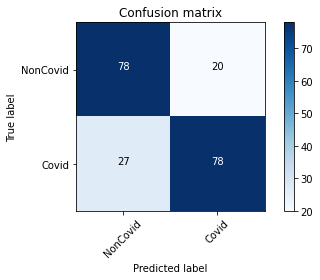

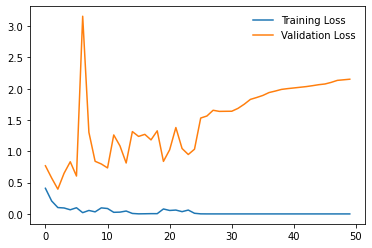

In [18]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096,2)
run_model(model, name = dir+"/vgg16-v3",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 1.9952 Acc: 0.7270
val Loss: 0.7817 Acc: 0.6864

Epoch 2/50
----------
train Loss: 0.1346 Acc: 0.9530
val Loss: 0.4905 Acc: 0.8051

Epoch 3/50
----------
train Loss: 0.0685 Acc: 0.9754
val Loss: 0.9254 Acc: 0.6695

Epoch 4/50
----------
train Loss: 0.0729 Acc: 0.9768
val Loss: 0.6415 Acc: 0.7797

Epoch 5/50
----------
train Loss: 0.0319 Acc: 0.9895
val Loss: 0.5445 Acc: 0.8136

Epoch 6/50
----------
train Loss: 0.0170 Acc: 0.9951
val Loss: 0.5957 Acc: 0.8136

Epoch 7/50
----------
train Loss: 0.0171 Acc: 0.9958
val Loss: 0.7944 Acc: 0.7119

Epoch 8/50
----------
train Loss: 0.0189 Acc: 0.9923
val Loss: 0.6694 Acc: 0.8305

Epoch 9/50
----------
train Loss: 0.0604 Acc: 0.9818
val Loss: 0.6684 Acc: 0.8220

Epoch 10/50
----------
train Loss: 0.0556 Acc: 0.9796
val Loss: 0.5945 Acc: 0.7881

Epoch 11/50
----------
train Loss: 0.0314 Acc: 0.9902
val Loss: 0.8526 Acc: 0.6780

Epoch 12/50
----------
train Loss: 0.0071 Acc: 0.9972
val Loss: 0.60

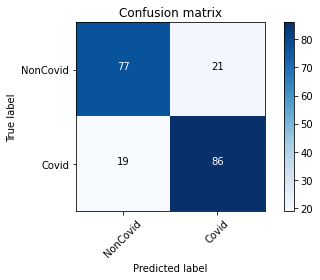

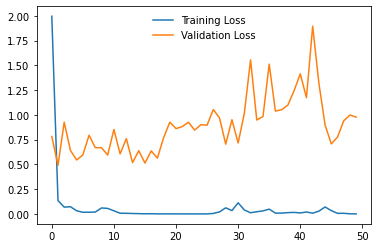

In [19]:
model = models.resnet101(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = dir+"/resnet101-v3",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 1.9246 Acc: 0.7333
val Loss: 1.1339 Acc: 0.5169

Epoch 2/50
----------
train Loss: 0.1160 Acc: 0.9586
val Loss: 1.0183 Acc: 0.7542

Epoch 3/50
----------
train Loss: 0.0560 Acc: 0.9782
val Loss: 0.9890 Acc: 0.7203

Epoch 4/50
----------
train Loss: 0.0314 Acc: 0.9909
val Loss: 0.9605 Acc: 0.7966

Epoch 5/50
----------
train Loss: 0.0212 Acc: 0.9930
val Loss: 1.0297 Acc: 0.7119

Epoch 6/50
----------
train Loss: 0.0566 Acc: 0.9818
val Loss: 0.9450 Acc: 0.7542

Epoch 7/50
----------
train Loss: 0.0242 Acc: 0.9902
val Loss: 0.8751 Acc: 0.7034

Epoch 8/50
----------
train Loss: 0.0385 Acc: 0.9853
val Loss: 1.0819 Acc: 0.7034

Epoch 9/50
----------
train Loss: 0.0333 Acc: 0.9916
val Loss: 1.0044 Acc: 0.7458

Epoch 10/50
----------
train Loss: 0.0327 Acc: 0.9888
val Loss: 1.2643 Acc: 0.7627

Epoch 11/50
----------
train Loss: 0.0330 Acc: 0.9909
val Loss: 1.0080 Acc: 0.7966

Epoch 12/50
----------
train Loss: 0.0112 Acc: 0.9972
val Loss: 1.00

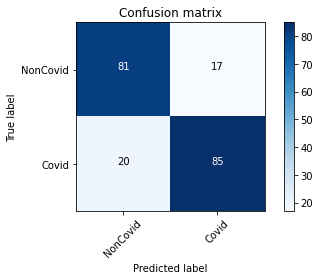

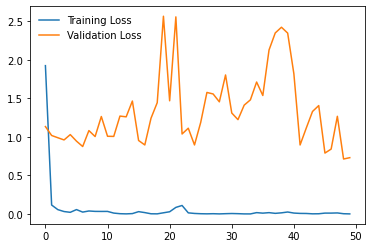

In [20]:
model = models.resnet152(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = dir+"/resnet152-v3",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 2.1549 Acc: 0.6940
val Loss: 0.8799 Acc: 0.7627

Epoch 2/50
----------
train Loss: 0.1585 Acc: 0.9404
val Loss: 0.6668 Acc: 0.7966

Epoch 3/50
----------
train Loss: 0.0758 Acc: 0.9740
val Loss: 0.4890 Acc: 0.7966

Epoch 4/50
----------
train Loss: 0.0508 Acc: 0.9839
val Loss: 1.4171 Acc: 0.6102

Epoch 5/50
----------
train Loss: 0.0425 Acc: 0.9860
val Loss: 1.2085 Acc: 0.6949

Epoch 6/50
----------
train Loss: 0.0334 Acc: 0.9867
val Loss: 1.0162 Acc: 0.7034

Epoch 7/50
----------
train Loss: 0.0241 Acc: 0.9937
val Loss: 0.7497 Acc: 0.7797

Epoch 8/50
----------
train Loss: 0.0162 Acc: 0.9951
val Loss: 0.7484 Acc: 0.7881

Epoch 9/50
----------
train Loss: 0.0115 Acc: 0.9958
val Loss: 0.8692 Acc: 0.7458

Epoch 10/50
----------
train Loss: 0.0282 Acc: 0.9923
val Loss: 0.7736 Acc: 0.7966

Epoch 11/50
----------
train Loss: 0.0278 Acc: 0.9902
val Loss: 0.8013 Acc: 0.7881

Epoch 12/50
----------
train Loss: 0.0122 Acc: 0.9951
val Loss: 0.76

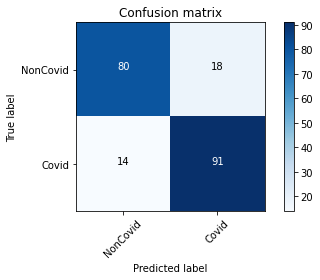

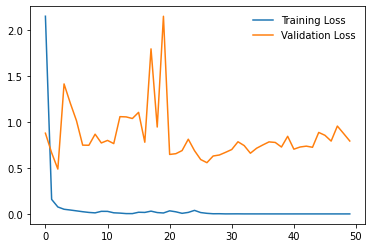

In [21]:
model = models.resnet50(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = dir+"/resnet50-v3",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 3.0579 Acc: 0.6091
val Loss: 1.2430 Acc: 0.6864

Epoch 2/50
----------
train Loss: 0.1912 Acc: 0.9509
val Loss: 0.7791 Acc: 0.7712

Epoch 3/50
----------
train Loss: 0.0856 Acc: 0.9761
val Loss: 0.8615 Acc: 0.7119

Epoch 4/50
----------
train Loss: 0.0711 Acc: 0.9747
val Loss: 0.7377 Acc: 0.8220

Epoch 5/50
----------
train Loss: 0.0324 Acc: 0.9888
val Loss: 1.4362 Acc: 0.6102

Epoch 6/50
----------
train Loss: 0.0246 Acc: 0.9958
val Loss: 1.0541 Acc: 0.7458

Epoch 7/50
----------
train Loss: 0.0159 Acc: 0.9951
val Loss: 0.9553 Acc: 0.7627

Epoch 8/50
----------
train Loss: 0.0126 Acc: 0.9979
val Loss: 1.1144 Acc: 0.7627

Epoch 9/50
----------
train Loss: 0.0148 Acc: 0.9979
val Loss: 0.9744 Acc: 0.7627

Epoch 10/50
----------
train Loss: 0.0095 Acc: 0.9979
val Loss: 1.0996 Acc: 0.7797

Epoch 11/50
----------
train Loss: 0.0092 Acc: 0.9993
val Loss: 0.9819 Acc: 0.7458

Epoch 12/50
----------
train Loss: 0.0041 Acc: 0.9993
val Loss: 0.92

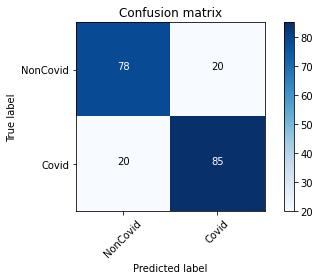

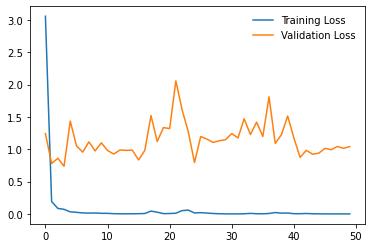

In [22]:
model = models.resnet18(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = dir+"/resnet18-v3",  freeze = True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 0.3367 Acc: 0.8414
val Loss: 0.4858 Acc: 0.6864

Epoch 2/50
----------
train Loss: 0.1303 Acc: 0.9551
val Loss: 0.5051 Acc: 0.7542

Epoch 3/50
----------
train Loss: 0.0496 Acc: 0.9902
val Loss: 0.4053 Acc: 0.8136

Epoch 4/50
----------
train Loss: 0.0214 Acc: 0.9958
val Loss: 0.3799 Acc: 0.8559

Epoch 5/50
----------
train Loss: 0.0341 Acc: 0.9874
val Loss: 0.6589 Acc: 0.7712

Epoch 6/50
----------
train Loss: 0.0240 Acc: 0.9930
val Loss: 0.8320 Acc: 0.7458

Epoch 7/50
----------
train Loss: 0.0166 Acc: 0.9965
val Loss: 0.6503 Acc: 0.8051

Epoch 8/50
----------
train Loss: 0.0120 Acc: 0.9979
val Loss: 0.8844 Acc: 0.7712

Epoch 9/50
----------
train Loss: 0.0050 Acc: 0.9986
val Loss: 0.6889 Acc: 0.7881

Epoch 10/50
----------
train Loss: 0.0134 Acc: 0.9965
val Loss: 0.6971 Acc: 0.8220

Epoch 11/50
----------
train Loss: 0.0079 Acc: 0.9986
val Loss: 0.7777 Acc: 0.7034

Epoch 12/50
----------
train Loss: 0.0052 Acc: 0.9993
val Loss: 0.61

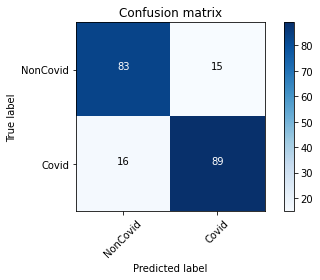

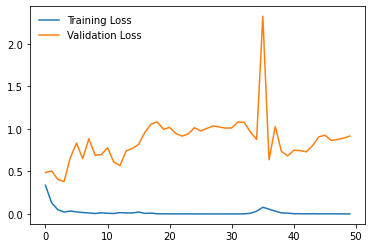

In [23]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = dir+"/densenet121-v3",  freeze = True)

In [24]:
get_ipython().system('pip install --upgrade efficientnet-pytorch')

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=554036cc7abdd88c6a9a56ff5ae526ab288105f2587aa5e20b0d5f2c5c33bc94
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [25]:
class Swish(nn.Module):
    def forward(self, input_tensor):
        return input_tensor * torch.sigmoid(input_tensor)

In [26]:
from efficientnet_pytorch import EfficientNet

class EfficientNet_b0(nn.Module):
    def __init__(self):
        super(EfficientNet_b0, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
        
        self.layer10 = nn.Sequential(
            nn.BatchNorm1d(1280),
            nn.Dropout(0.8)
        )
        self.layer11a = nn.Sequential(
            nn.Linear(1280, 2048),
            nn.BatchNorm1d(2048),
            Swish(),
            nn.Dropout(0.8)
        )
        self.layer11b = nn.Sequential(
            nn.Linear(2048 , 1024),
            nn.BatchNorm1d(1024), 
            Swish(),
            nn.Dropout(0.8)
        )
        self.layer12 = nn.Sequential(
            nn.Linear(1024 , 512),
            nn.BatchNorm1d(512),
            Swish()
        )
        self.layer13 = nn.Sequential(
            nn.Linear(512 , 2),
            nn.Softmax()
        )
        
    def forward(self, inputs):
        x = self.model.extract_features(inputs)

        # Pooling and final linear layer
        x = self.model._avg_pooling(x)
        x = x.flatten(start_dim=1)
        x = self.model._dropout(x)
        x = self.layer10(x)
        x = self.layer11a(x)
        x = self.layer11b(x)
        x = self.layer12(x)
        x = self.layer13(x)
        return x

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0
Using GPU: True
Epoch 1/50
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train Loss: 0.6905 Acc: 0.5495
val Loss: 0.6943 Acc: 0.5085

Epoch 2/50
----------
train Loss: 0.6272 Acc: 0.6849
val Loss: 0.7238 Acc: 0.5085

Epoch 3/50
----------
train Loss: 0.5051 Acc: 0.8344
val Loss: 0.7491 Acc: 0.5085

Epoch 4/50
----------
train Loss: 0.4298 Acc: 0.9011
val Loss: 0.7648 Acc: 0.5254

Epoch 5/50
----------
train Loss: 0.4024 Acc: 0.9186
val Loss: 0.7425 Acc: 0.5424

Epoch 6/50
----------
train Loss: 0.3874 Acc: 0.9326
val Loss: 0.6950 Acc: 0.5932

Epoch 7/50
----------
train Loss: 0.3614 Acc: 0.9628
val Loss: 0.7099 Acc: 0.5593

Epoch 8/50
----------
train Loss: 0.3590 Acc: 0.9600
val Loss: 0.6575 Acc: 0.6186

Epoch 9/50
----------
train Loss: 0.3543 Acc: 0.9628
val Loss: 0.6914 Acc: 0.5847

Epoch 10/50
----------
train Loss: 0.3492 Acc: 0.9649
val Loss: 0.6228 Acc: 0.6525

Epoch 11/50
----------
train Loss: 0.3376 Acc: 0.9832
val Loss: 0.6007 Acc: 0.6949

Epoch 12/50
----------
train Loss: 0.3457 Acc: 0.9719
val Loss: 0.6241 Acc: 0.6525

Epoch 13/50
----------


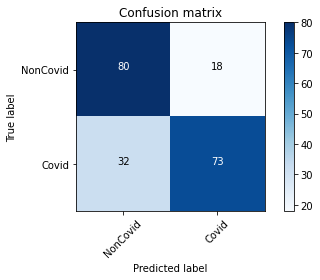

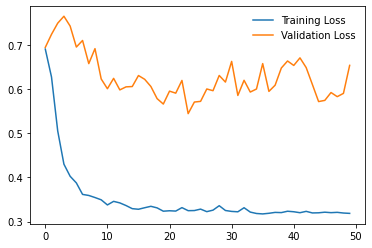

In [27]:
### efficientCovidNet
model = EfficientNet_b0()
run_model(model, name = dir+"/EfficientNet_b0-v3",  freeze = True)

<h1>Plot All Losses</h1>

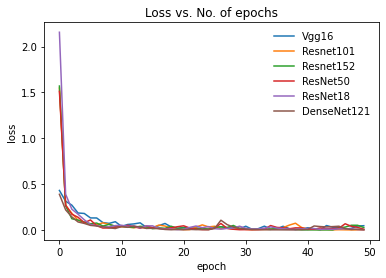

In [ ]:
def plot_all_losses(losses, t):
    plt.figure()
    models = ['Vgg16', 'Resnet101','Resnet152', 'ResNet50', 'ResNet18', 'DenseNet121']

    for i, val in enumerate(losses):
        plt.plot(val, label=models[i])
        plt.legend(frameon=False)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')   
    plt.savefig("plots/sagan/git/"+dir+"/"+t+"_losses_resnet.png")
    plt.show()
        
plot_all_losses(train_losses_all, t="training")

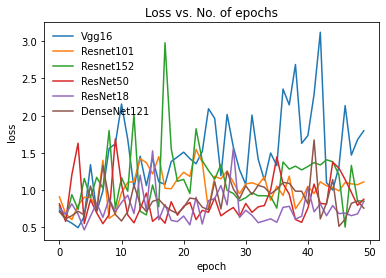

In [ ]:
plot_all_losses(test_losses_all, t="testing")

<h1>Testing trained models on Sars_Cov_2 on CT_COVID dataset test set</h1>

In [18]:
#densenet121_epoch_50.pth
#resnet18_epoch_50.pth
#resnet50_epoch_50.pth
#resnet101_epoch_50.pth
#resnet152_epoch_50.pth
#vgg16_epoch_50.pth

test_transform = transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

images_covid = "revised-git/"
test_datasets = datasets.ImageFolder(os.path.join(images_covid, 'test'),transform= test_transform)

test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=32, shuffle=True, num_workers=4)

In [19]:
print(len(test_loader))

7


Testing Accuracy: 0.116
Testing Accuracy: 0.223
Testing Accuracy: 0.344
Testing Accuracy: 0.451
Testing Accuracy: 0.558
Testing Accuracy: 0.683
Testing Accuracy: 0.800
[[67 31]
 [10 95]]
[68.36734694 90.47619048]
Accuracy score: 0.7980295566502463
              precision    recall  f1-score   support

           0       0.87      0.68      0.77        98
           1       0.75      0.90      0.82       105

    accuracy                           0.80       203
   macro avg       0.81      0.79      0.79       203
weighted avg       0.81      0.80      0.80       203

Confusion matrix, without normalization
[[67 31]
 [10 95]]


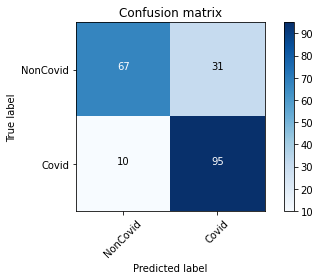

In [20]:
loaded_model = torch.load("model_backup/sagan/git/batch_size=64,epoch=1500/resnet152_epoch_50.pth")
name = "resnet152"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.025
Testing Accuracy: 0.043
Testing Accuracy: 0.068
Testing Accuracy: 0.089
Testing Accuracy: 0.116
Testing Accuracy: 0.139
Testing Accuracy: 0.157
[[56 42]
 [45 60]]
[57.14285714 57.14285714]
Accuracy score: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.55      0.57      0.56        98
           1       0.59      0.57      0.58       105

    accuracy                           0.57       203
   macro avg       0.57      0.57      0.57       203
weighted avg       0.57      0.57      0.57       203

Confusion matrix, without normalization
[[56 42]
 [45 60]]


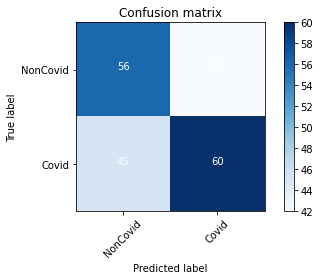

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet152_epoch_50.pth")
name = "resnet152_epoch_50_on_git_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.016
Testing Accuracy: 0.032
Testing Accuracy: 0.059
Testing Accuracy: 0.079
Testing Accuracy: 0.100
Testing Accuracy: 0.120
Testing Accuracy: 0.145
[[30 68]
 [32 73]]
[30.6122449  69.52380952]
Accuracy score: 0.5073891625615764
              precision    recall  f1-score   support

           0       0.48      0.31      0.38        98
           1       0.52      0.70      0.59       105

    accuracy                           0.51       203
   macro avg       0.50      0.50      0.48       203
weighted avg       0.50      0.51      0.49       203

Confusion matrix, without normalization
[[30 68]
 [32 73]]


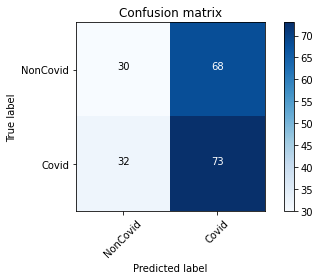

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet101_epoch_50.pth")
name = "resnet101_epoch_50_on_git_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.024
Testing Accuracy: 0.043
Testing Accuracy: 0.060
Testing Accuracy: 0.083
Testing Accuracy: 0.106
Testing Accuracy: 0.121
Testing Accuracy: 0.143
[[37 61]
 [39 66]]
[37.75510204 62.85714286]
Accuracy score: 0.5073891625615764
              precision    recall  f1-score   support

           0       0.49      0.38      0.43        98
           1       0.52      0.63      0.57       105

    accuracy                           0.51       203
   macro avg       0.50      0.50      0.50       203
weighted avg       0.50      0.51      0.50       203

Confusion matrix, without normalization
[[37 61]
 [39 66]]


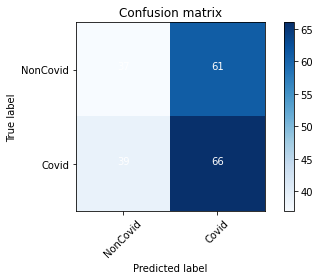

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet50_epoch_50.pth")
name = "resnet50_epoch_50_on_git_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.023
Testing Accuracy: 0.044
Testing Accuracy: 0.061
Testing Accuracy: 0.080
Testing Accuracy: 0.101
Testing Accuracy: 0.121
Testing Accuracy: 0.143
[[36 62]
 [38 67]]
[36.73469388 63.80952381]
Accuracy score: 0.5073891625615764
              precision    recall  f1-score   support

           0       0.49      0.37      0.42        98
           1       0.52      0.64      0.57       105

    accuracy                           0.51       203
   macro avg       0.50      0.50      0.50       203
weighted avg       0.50      0.51      0.50       203

Confusion matrix, without normalization
[[36 62]
 [38 67]]


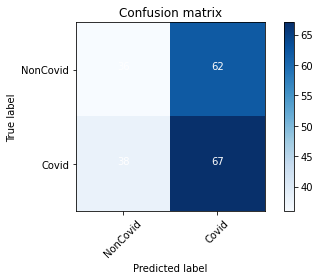

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet18_epoch_50.pth")
name = "resnet18_epoch_50_on_git_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.023
Testing Accuracy: 0.040
Testing Accuracy: 0.064
Testing Accuracy: 0.087
Testing Accuracy: 0.105
Testing Accuracy: 0.124
Testing Accuracy: 0.138
[[36 62]
 [38 67]]
[36.73469388 63.80952381]
Accuracy score: 0.5073891625615764
              precision    recall  f1-score   support

           0       0.49      0.37      0.42        98
           1       0.52      0.64      0.57       105

    accuracy                           0.51       203
   macro avg       0.50      0.50      0.50       203
weighted avg       0.50      0.51      0.50       203

Confusion matrix, without normalization
[[36 62]
 [38 67]]


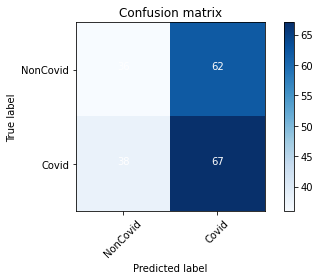

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet18_epoch_50.pth")
name = "resnet18_epoch_50_on_git_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.038
Testing Accuracy: 0.078
Testing Accuracy: 0.115
Testing Accuracy: 0.150
Testing Accuracy: 0.186
Testing Accuracy: 0.225
Testing Accuracy: 0.262
Testing Accuracy: 0.303
Testing Accuracy: 0.339
Testing Accuracy: 0.376
Testing Accuracy: 0.414
Testing Accuracy: 0.452
Testing Accuracy: 0.491
Testing Accuracy: 0.529
Testing Accuracy: 0.569
Testing Accuracy: 0.604
Testing Accuracy: 0.642
Testing Accuracy: 0.675
Testing Accuracy: 0.711
Testing Accuracy: 0.748
Testing Accuracy: 0.785
Testing Accuracy: 0.820
Testing Accuracy: 0.855
Testing Accuracy: 0.891
Testing Accuracy: 0.922
[[323   6]
 [ 53 403]]
[98.17629179 88.37719298]
Accuracy score: 0.9248407643312102
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       329
           1       0.99      0.88      0.93       456

    accuracy                           0.92       785
   macro avg       0.92      0.93      0.92       785
weighted avg       0.93      0.92      0.93 

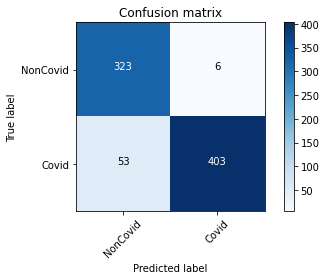

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/densenet121_epoch_50.pth")
name = "densenet121_epoch_50_epoch_50_on_git_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)